In [1]:
using BenchmarkTools
using Combinatorics
using Distributions
using HypothesisTests
using Memoization
using StatsBase
using StatsPlots

$\{1,2,\ldots,N\}$ から重複無しに $m$ 個の組み合わせ $1\le i_1<\cdots<i_m\le N$ を取るとき, その和が $r$ になる場合の数を $f(N, m, r)$ と書くと, 以下が成立することがわかる:

$$
\begin{aligned}
&
f(N, m, r) = 0\quad\text{unless $0\le m \le N$ and $0\le r - m(m+1)/2 \le m(N-m)$},
\\ &
f(N, 0, 0) = 1,
\\ &
f(N, 1, r) = \text{if $1\le r\le N$ then $1$ else $0$},
\\ &
f(N, m, r) = f(N-1, m, r) + f(N-1, m-1, r-N).
\end{aligned}
$$

ただし, この方法で計算するにはメモ化がほぼ必須である.

以下のセルのコードは上の方法による $f(N, m, r)$ の計算法をそのままコードに翻訳したものである.

In [2]:
function f_naive(N, m, r)
    0 ≤ m ≤ N || return zero(N)
    0 ≤ r - m*(m+1)÷2 ≤ m*(N-m) || return zero(N)
    m == 0 && return one(N)
    m == 1 && return 1 ≤ r ≤ N ? one(N) : zero(N)
    f_naive(N-1, m, r) + f_naive(N-1, m-1, r-N)
end

@memoize function f_memoize(N, m, r)
    0 ≤ m ≤ N || return zero(N)
    0 ≤ r - m*(m+1)÷2 ≤ m*(N-m) || return zero(N)
    m == 0 && return one(N)
    m == 1 && return 1 ≤ r ≤ N ? one(N) : zero(N)
    f_memoize(N-1, m, r) + f_memoize(N-1, m-1, r-N)
end

f_memoize (generic function with 1 method)

メモ化していない `f_naive` はひどく遅い.

In [3]:
for m in 10:18
    N = 2m
    r = m*(m+1)÷2 + m*(N-m)÷2
    print("m = $m, N = $N, r = $r: ")
    @time f_naive(N, m, r)
end

m = 10, N = 20, r = 105:   0.000136 seconds
m = 11, N = 22, r = 126:   0.000441 seconds
m = 12, N = 24, r = 150:   0.001464 seconds
m = 13, N = 26, r = 175:   0.005046 seconds
m = 14, N = 28, r = 203:   0.018274 seconds
m = 15, N = 30, r = 232:   0.062796 seconds
m = 16, N = 32, r = 264:   0.242667 seconds
m = 17, N = 34, r = 297:   0.791636 seconds
m = 18, N = 36, r = 333:   2.812112 seconds


メモ化された `f` はこれよりかなり速くなっている.

In [4]:
for m in 10:18
    N = 2m
    r = m*(m+1)÷2 + m*(N-m)÷2
    print("m = $m, N = $N, r = $r: ")
    @time f_memoize(N, m, r)
end

m = 10, N = 20, r = 105:   0.016676 seconds (4.74 k allocations: 298.744 KiB, 98.84% compilation time)
m = 11, N = 22, r = 126:   0.000085 seconds (896 allocations: 27.094 KiB)
m = 12, N = 24, r = 150:   0.000307 seconds (1.48 k allocations: 44.312 KiB)
m = 13, N = 26, r = 175:   0.000144 seconds (1.62 k allocations: 47.719 KiB)
m = 14, N = 28, r = 203:   0.000417 seconds (2.45 k allocations: 71.375 KiB)
m = 15, N = 30, r = 232:   0.000463 seconds (2.78 k allocations: 334.672 KiB)
m = 16, N = 32, r = 264:   0.000243 seconds (3.83 k allocations: 109.281 KiB)
m = 17, N = 34, r = 297:   0.000334 seconds (4.24 k allocations: 117.812 KiB)
m = 18, N = 36, r = 333:   0.000540 seconds (5.72 k allocations: 160.094 KiB)


念のために正しく計算されていることを確認しておこう.

以下では $N = n + m$ とおく.

In [5]:
function F_memoize(n, m)
    rmin = m*(m+1)÷2
    rmax = rmin + m*n
    rs = rmin:rmax
    fs = [f_memoize(n+m, m, r) for r in rs]
    rs, fs
end

function F_comb(n, m)
    rank_sums = [sum(comb) for comb in combinations(1:(n+m), m)]
    c = countmap(rank_sums)
    rmin, rmax = extrema(keys(c))
    rs = rmin:rmax
    fs = [c[k] for k in rs]
    rs, fs
end

F_comb (generic function with 1 method)

In [6]:
N = 10
F1 = F_memoize
F2 = F_comb
for m in 0:N
    @show N, m, F1(N-m, m)
    @show N, m, F2(N-m, m)
    @show F1(N-m, m) == F2(N-m, m)
    println()
end

(N, m, F1(N - m, m)) = (10, 0, (0:0, [1]))
(N, m, F2(N - m, m)) = (10, 0, (0:0, [1]))
F1(N - m, m) == F2(N - m, m) = true

(N, m, F1(N - m, m)) = (10, 1, (1:10, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
(N, m, F2(N - m, m)) = (10, 1, (1:10, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
F1(N - m, m) == F2(N - m, m) = true

(N, m, F1(N - m, m)) = (10, 2, (3:19, [1, 1, 2, 2, 3, 3, 4, 4, 5, 4, 4, 3, 3, 2, 2, 1, 1]))
(N, m, F2(N - m, m)) = (10, 2, (3:19, [1, 1, 2, 2, 3, 3, 4, 4, 5, 4, 4, 3, 3, 2, 2, 1, 1]))
F1(N - m, m) == F2(N - m, m) = true

(N, m, F1(N - m, m)) = (10, 3, (6:27, [1, 1, 2, 3, 4, 5, 7, 8, 9, 10, 10, 10, 10, 9, 8, 7, 5, 4, 3, 2, 1, 1]))
(N, m, F2(N - m, m)) = (10, 3, (6:27, [1, 1, 2, 3, 4, 5, 7, 8, 9, 10, 10, 10, 10, 9, 8, 7, 5, 4, 3, 2, 1, 1]))
F1(N - m, m) == F2(N - m, m) = true

(N, m, F1(N - m, m)) = (10, 4, (10:34, [1, 1, 2, 3, 5, 6, 9, 10, 13, 14, 16, 16, 18, 16, 16, 14, 13, 10, 9, 6, 5, 3, 2, 1, 1]))
(N, m, F2(N - m, m)) = (10, 4, (10:34, [1, 1, 2, 3, 5, 6, 9, 10, 13, 14, 16, 16, 18, 16, 1

In [7]:
[F_memoize(n, m) == F_comb(n, m) for n in 0:10, m in 0:10]

11×11 Matrix{Bool}:
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1

In [8]:
for m in 25:5:50
    n = m
    print("n = $n, m = $m: ")
    @time F_memoize(m, m)
end

n = 25, m = 25:   0.053664 seconds (559.43 k allocations: 19.682 MiB)
n = 30, m = 30:   0.116252 seconds (642.06 k allocations: 16.590 MiB)
n = 35, m = 35:   0.303532 seconds (1.06 M allocations: 35.240 MiB, 10.95% gc time)
n = 40, m = 40:   0.948871 seconds (1.62 M allocations: 57.670 MiB, 6.37% gc time)
n = 45, m = 45:   2.701299 seconds (2.36 M allocations: 92.451 MiB, 4.27% gc time)
n = 50, m = 50:   0.662752 seconds (3.29 M allocations: 84.157 MiB, 21.15% gc time)


$$
\begin{aligned}
&
f(N, m, r) = 0\quad\text{unless $0\le m \le N$ and $0\le r - m(m+1)/2 \le m(N-m)$},
\\ &
f(N, 0, 0) = 1,
\\ &
f(N, 1, r) = \text{if $1\le r\le N$ then $1$ else $0$},
\\ &
f(N, m, r) = f(N-1, m, r) + f(N-1, m-1, r-N).
\end{aligned}
$$

より,

$$
N = m + n, \quad
r = m(m+1)/2 + u, \quad
g(n, m, u) = f(m+n, m, m(m+1)/2 + u)
$$

とおくと,

$$
\begin{aligned}
&
g(n, m, u) = 0\quad\text{unless $0 \le m$, $0\le n$, and $0\le u \le mn$},
\\ &
g(n, 0, 0) = 1,
\\ &
g(n, 1, u) = \text{if $0\le u \le m+n-1$ then $1$ else $0$},
\\ &
g(n, m, u) = g(n-1, m, u) + g(n, m-1, u-n).
\end{aligned}
$$

特に,

$$
g(0, 1, u) = \text{if $u=0$ then $1$ else $0$}.
$$

$g(n, m, u)$ の値は以下を帰納的に計算すれば得られる:

$$
g(j, i, u-(n-j)n), \quad 0\le j\le n, \quad 0\le i \le m.
$$

In [9]:
function G(n, m,
        prev = Matrix{Int}(undef, m*n+1, m+1),
        next = similar(prev),
    )
    # g(0, i, u) = δ_{i0} δ_{u0}
    @. next = 0
    next[1+0, 1+0] = 1
    for k in 1:m+n
        @. prev = next
        for i in max(0, k-n):min(m, k)
            j = k - i
            # g(j, i, u) = g(j-1, i, u) + g(j, i-1, u-j)
            @views @. next[1:1+i*(j-1), 1+i] = prev[1:1+i*(j-1), 1+i]
            if i ≥ 1
                @views @. next[1+j:1+i*j, 1+i] += prev[1:1+(i-1)*j, 1+i-1]
            end
            # g(0, i, u) = δ_{i0} δ_{u0}
            if j == 0
                next[1+0, 1+i] = 1
            end
        end
    end
    @view next[:, 1+m]
end

function F_recursive(n, m,
        prev = Matrix{Int}(undef, m*n+1, m+1),
        next = similar(prev),
    )
    rmin = m*(m+1)÷2
    rmax = rmin + m*n
    rs = rmin:rmax
    fs = G(n, m, prev, next)
    rs, fs
end

F_recursive (generic function with 3 methods)

In [10]:
N = 10
F1 = F_memoize
F2 = F_recursive
for m in 0:N
    @show N, m, F1(N-m, m)
    @show N, m, F2(N-m, m)
    @show F1(N-m, m) == F2(N-m, m)
    println()
end

(N, m, F1(N - m, m)) = (10, 0, (0:0, [1]))
(N, m, F2(N - m, m)) = (10, 0, (0:0, [1]))
F1(N - m, m) == F2(N - m, m) = true

(N, m, F1(N - m, m)) = (10, 1, (1:10, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
(N, m, F2(N - m, m)) = (10, 1, (1:10, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
F1(N - m, m) == F2(N - m, m) = true

(N, m, F1(N - m, m)) = (10, 2, (3:19, [1, 1, 2, 2, 3, 3, 4, 4, 5, 4, 4, 3, 3, 2, 2, 1, 1]))
(N, m, F2(N - m, m)) = (10, 2, (3:19, [1, 1, 2, 2, 3, 3, 4, 4, 5, 4, 4, 3, 3, 2, 2, 1, 1]))
F1(N - m, m) == F2(N - m, m) = true

(N, m, F1(N - m, m)) = (10, 3, (6:27, [1, 1, 2, 3, 4, 5, 7, 8, 9, 10, 10, 10, 10, 9, 8, 7, 5, 4, 3, 2, 1, 1]))
(N, m, F2(N - m, m)) = (10, 3, (6:27, [1, 1, 2, 3, 4, 5, 7, 8, 9, 10, 10, 10, 10, 9, 8, 7, 5, 4, 3, 2, 1, 1]))
F1(N - m, m) == F2(N - m, m) = true

(N, m, F1(N - m, m)) = (10, 4, (10:34, [1, 1, 2, 3, 5, 6, 9, 10, 13, 14, 16, 16, 18, 16, 16, 14, 13, 10, 9, 6, 5, 3, 2, 1, 1]))
(N, m, F2(N - m, m)) = (10, 4, (10:34, [1, 1, 2, 3, 5, 6, 9, 10, 13, 14, 16, 16, 18, 16, 1

In [11]:
[F_recursive(n, m) == F_memoize(n, m) for n in 0:20, m in 0:20]

21×21 Matrix{Bool}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1

In [12]:
for m in 25:5:100
    n = m
    print("n = $n, m = $m: ")
    prev = Matrix{Int}(undef, m*n+1, m+1)
    next = similar(prev)
    @time G(n, m, prev, next)
end

n = 25, m = 25:   0.000436 seconds
n = 30, m = 30:   0.000815 seconds
n = 35, m = 35:   0.002111 seconds
n = 40, m = 40:   0.002967 seconds
n = 45, m = 45:   0.004342 seconds
n = 50, m = 50:   0.006514 seconds
n = 55, m = 55:   0.009639 seconds
n = 60, m = 60:   0.012622 seconds
n = 65, m = 65:   0.017027 seconds
n = 70, m = 70:   0.037088 seconds
n = 75, m = 75:   0.035207 seconds
n = 80, m = 80:   0.042431 seconds
n = 85, m = 85:   0.057118 seconds
n = 90, m = 90:   0.074494 seconds
n = 95, m = 95:   0.113463 seconds
n = 100, m = 100:   0.130680 seconds


In [13]:
n, m = 100, 100
prev = Matrix{Int}(undef, m*n+1, m+1)
next = similar(prev)
@btime F_recursive($n, $m, $prev, $next);

  110.468 ms (0 allocations: 0 bytes)


In [14]:
n, m = 100, 100
x, y = rand(m), rand(n)
@time ExactMannWhitneyUTest(x, y)
@time ExactMannWhitneyUTest(x, y)
@time ExactMannWhitneyUTest(x, y)

  0.175566 seconds (450.42 k allocations: 24.188 MiB, 99.81% compilation time)
  0.000030 seconds (7 allocations: 7.125 KiB)
  0.000030 seconds (7 allocations: 7.125 KiB)


Exact Mann-Whitney U test
-------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.14131

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0051

Details:
    number of observations in each group: [100, 100]
    Mann-Whitney-U statistic:             6143.0
    rank sums:                            [11193.0, 8907.0]
    adjustment for ties:                  0.0


  0.169909 seconds (61 allocations: 3.391 KiB, 3.71% compilation time)
rs = 5050:15050
length(fs) = 10001
typeof(fs) = SubArray{Int64, 1, Matrix{Int64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}
mu = (m * (m + n + 1)) / 2 = 10050.0
s2 = (m * n * (m + n + 1)) / 12 = 167500.0


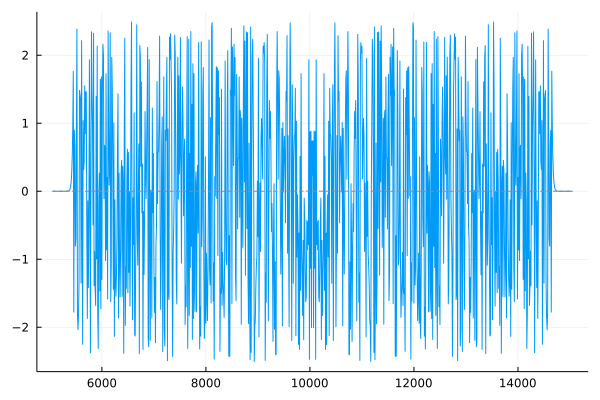

In [15]:
n, m = 100, 100
prev = Matrix{Int}(undef, m*n+1, m+1)
next = similar(prev)
rs, fs = @time F_recursive(n, m, prev, next)
@show rs length(fs) typeof(fs)

ps = fs/sum(fs)
@show mu = m*(m+n+1)/2
@show s2 = m*n*(m+n+1)/12

plot(rs[begin:10:end], ps[begin:10:end]; label="")
plot!(Normal(mu, √s2), extrema(rs)...; ls=:dash, label="")

In [16]:
extrema(fs)

(-9222401425054171578, 9216776092804628317)

  0.714719 seconds (1.64 M allocations: 81.917 MiB, 4.95% gc time, 52.99% compilation time)
rs = 5050:15050
length(fs) = 10001
typeof(fs) = SubArray{Int128, 1, Matrix{Int128}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}
mu = (m * (m + n + 1)) / 2 = 10050.0
s2 = (m * n * (m + n + 1)) / 12 = 167500.0


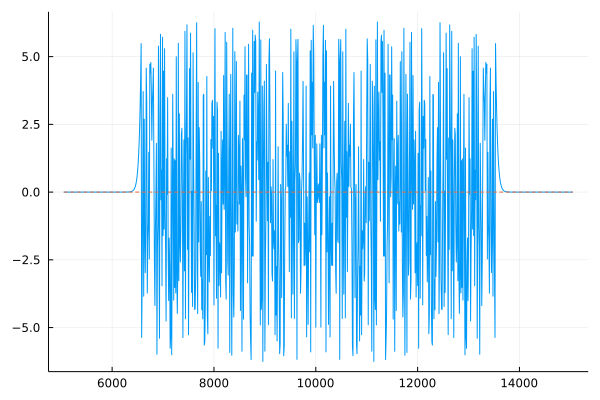

In [17]:
n, m = 100, 100
prev = Matrix{Int128}(undef, m*n+1, m+1)
next = similar(prev)
rs, fs = @time F_recursive(n, m, prev, next)
@show rs length(fs) typeof(fs)

ps = fs/sum(fs)
@show mu = m*(m+n+1)/2
@show s2 = m*n*(m+n+1)/12

plot(rs[begin:10:end], ps[begin:10:end]; label="")
plot!(Normal(mu, √s2), extrema(rs)...; ls=:dash, label="")

In [18]:
extrema(fs)

(-170088247345538178547583028545249299815, 170124715978365220510458557032888198960)

  5.480208 seconds (51.67 M allocations: 1.362 GiB, 32.72% gc time, 6.99% compilation time)
rs = 5050:15050
length(fs) = 10001
typeof(fs) = SubArray{BigInt, 1, Matrix{BigInt}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}
mu = (m * (m + n + 1)) / 2 = 10050.0
s2 = (m * n * (m + n + 1)) / 12 = 167500.0


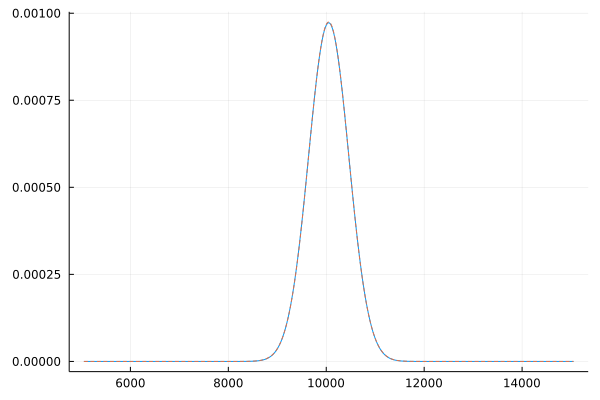

In [19]:
n, m = 100, 100
prev = Matrix{BigInt}(undef, m*n+1, m+1)
next = similar(prev)
rs, fs = @time F_recursive(n, m, prev, next)
@show rs length(fs) typeof(fs)

ps = fs/sum(fs)
@show mu = m*(m+n+1)/2
@show s2 = m*n*(m+n+1)/12

plot(rs[begin:10:end], ps[begin:10:end]; label="")
plot!(Normal(mu, √s2), extrema(rs)...; ls=:dash, label="")

In [20]:
extrema(fs)

(1, 88064925963069745337300842293630181021718294488842002448)

  0.507928 seconds (1.63 M allocations: 81.049 MiB, 74.61% compilation time)
rs = 5050:15050
length(fs) = 10001
typeof(fs) = SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}
mu = (m * (m + n + 1)) / 2 = 10050.0
s2 = (m * n * (m + n + 1)) / 12 = 167500.0


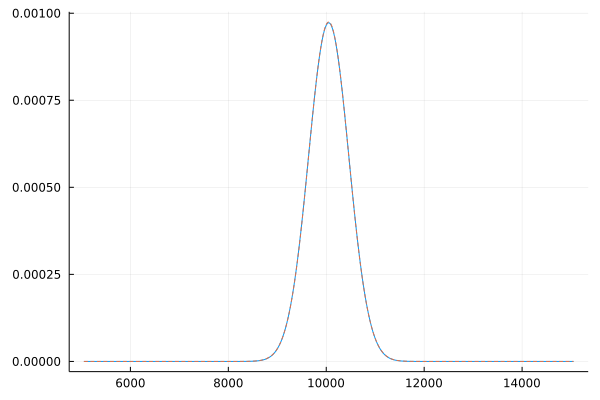

In [21]:
n, m = 100, 100
prev = Matrix{Float64}(undef, m*n+1, m+1)
next = similar(prev)
rs, fs = @time F_recursive(n, m, prev, next)
@show rs length(fs) typeof(fs)

ps = fs/sum(fs)
@show mu = m*(m+n+1)/2
@show s2 = m*n*(m+n+1)/12

plot(rs[begin:10:end], ps[begin:10:end]; label="")
plot!(Normal(mu, √s2), extrema(rs)...; ls=:dash, label="")

In [22]:
extrema(fs)

(1.0, 8.806492596306974e55)

In [23]:
sum(fs)

9.054851465610328e58

In [24]:
binomial(big(200), 100)

90548514656103281165404177077484163874504589675413336841320

In [25]:
binomial(big(200), 100) |> float

9.054851465610328116540417707748416387450458967541333684132e+58